## What is Reinforcement Learning

- the goal is to find a function that maps the **state (s)** to an **action (a)**
- uses a reward function to train model **R(s)**

Applications
- Controlling robots
- factory optimization
- financial (stock) trading
- playing games (including video games)

### The Return in Reinforcement Learning
-  **discount factor (γ)**: modifies reward credited to each step, discounting rewards further in the future (often a number close to 1)
- the **return** in reinforcement learning is the **sum of the rewards the system gets** but **weighted by the discount factor** -> rewards in the future are weighted by the discount factor raised to a higher power

### Making Decisions: Policies in Reinforcement Learning
- a policy function, **π(s) = a**, tells you what **action (a)** to take in a given **state (s)**

- **goal**: fund a policy that tells you what action to take in every state (s) so as to maximize the return


### Markov Decision Process (MDP)
- model for sequential decision making when outcomes are uncertain and partly controllable
- "Markov" means that the future only depends on the current state

### State-Action Value Function (Q Function, Q*. Optimal Q Function)
- a function typicall denoted by **Q(s, a)**
    - gives a number equal to the return if you start in a **state (s)**, take the **action (a)** once, and behave optimally after that
    - tells us how good it is to take action a in state s
    - the best possible return from **state (s)** is **max Q(s, a)**

### Bellman Equation
- helps compute the state-action value function (**Q(s, a)**)
- terms
    - **s: current state**
    - **a: current action**
    - **s': state you get to after taking action a**
    - **a': action that you take in state s'**
    - **R(s) = rewards of current state**
- Equation: **Q(s, a) = R(s) + γ(max Q(s', a'))**

### Stochastic Environments
- sometimes, when you take an action, the outcome is not always completely reliable (i.e slippery floor causes robot to move in wrong direction, device thrown off balance, wind, etc)
- there isn't one sequence of rewards that you are guarenteed to see
- now, we are trying to maximize the **average or expected return**
- **Q(s, a) = R(s) + γ* E(max Q(s', a'))**

### Learning the State-Value Function
- key idea: train a neural network to compute / approximate the state action value function ((Q(s, a))) that will in turn let us pick good actions
- get Q(s, a) from NN, compute all options and select action that yeilds best reward
- for training 
    $$ x^{(1)} = (s^{(1)}, a^{(1)}) $$ 

    $$ y^{(1)} = R(s^{(1)}) + γmax Q(s^{'(1)}, a^{'}) $$ 
- at every step, Q will be a guess (that will get better over time)

### Full Algorithm
1. Initialize neural network parameters randomly as an initial random guess for the Q function 
2. Repeat 
    - Take actions in lunar lander. Get (s, a, R(s), s')
    - Store 10,000 most recent tuples (s, a, R(s), s') (called the replay buffer)
    - Occasionally train NN by creating training set of 10,000 examples -> x =(s, a), y = R(s) + γ*max(Q(s',a'))
    - Train such that $Q_{new} (s, a) ~= y$
    - set $ Q = Q_{new}$ 

     

### Algorithmic Refinement: Improved Neural Network Architecture
- previous would have to carry out inference in the neural network separetly for as many times as there are actions, to pick the action that gives the largest Q value
- instead, it is more efficient to train a single neural network to **output all action values simultaneously**

### Algorithmic Refinement: ϵ-greedy policy
- this is used to pick the actions while still learning (first bullet in full algorithm)
- with probability 0.95 (**95%** of the time), pick the action a that **maximizes Q(s, a)** -> Greedy/Explotation Step
- with probaility 0.05 (other **5%** of the time), pick action a **randomly** -> Exploration Step

### Algorithmic Refinement: Mini-Batch and Soft Updates
- **Mini Batches**
    - every step of gradient descent requires computing the error across every single example which can be quite slow
    - instead, pick a subset (m') and instead of using all examples, use m' examples to speed up the algorithm
    - good for both supervised and reinforcement learning
- **Soft Updates**
    - whenever we train a new neural network (Q_new), we will only update with a little portion of the new value 
        - $ W = 0.01*W_{new} + 0.99*W $
        - $ B = 0.01*B_{new} + 0.99*B $
    - increases convergence reliability

## Deep Q-Learning - Lunar Lander

- `numpy` is a package for scientific computing in python.
- `deque` will be our data structure for our memory buffer.
- `namedtuple` will be used to store the experience tuples.
- The `gym` toolkit is a collection of environments that can be used to test reinforcement learning algorithms. We should note that in this notebook we are using `gym` version `0.24.0`.
- `PIL.Image` and `pyvirtualdisplay` are needed to render the Lunar Lander environment.
- We will use several modules from the `tensorflow.keras` framework for building deep learning models.
- `utils` is a module that contains helper functions for this assignment. You do not need to modify the code in this file.

In [45]:
import time
from collections import deque, namedtuple

import gymnasium as gym
import numpy as np
from PIL import Image
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

In [46]:
MEMORY_SIZE = 100_000     # size of memory buffer
GAMMA = 0.995             # discount factor
ALPHA = 1e-3              # learning rate  
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps

### 3.1 Action Space

The agent has four discrete actions available:

* Do nothing.
* Fire right engine.
* Fire main engine.
* Fire left engine.

Each action has a corresponding numerical value:

```python
Do nothing = 0
Fire right engine = 1
Fire main engine = 2
Fire left engine = 3
```

<a name="3.2"></a>
### 3.2 Observation Space

The agent's observation space consists of a state vector with 8 variables:

* Its $(x,y)$ coordinates. The landing pad is always at coordinates $(0,0)$.
* Its linear velocities $(\dot x,\dot y)$.
* Its angle $\theta$.
* Its angular velocity $\dot \theta$.
* Two booleans, $l$ and $r$, that represent whether each leg is in contact with the ground or not.

<a name="3.3"></a>
### 3.3 Rewards

After every step, a reward is granted. The total reward of an episode is the sum of the rewards for all the steps within that episode.

For each step, the reward:
- is increased/decreased the closer/further the lander is to the landing pad.
- is increased/decreased the slower/faster the lander is moving.
- is decreased the more the lander is tilted (angle not horizontal).
- is increased by 10 points for each leg that is in contact with the ground.
- is decreased by 0.03 points each frame a side engine is firing.
- is decreased by 0.3 points each frame the main engine is firing.

The episode receives an additional reward of -100 or +100 points for crashing or landing safely respectively.

<a name="3.4"></a>
### 3.4 Episode Termination

An episode ends (i.e the environment enters a terminal state) if:

* The lunar lander crashes (i.e if the body of the lunar lander comes in contact with the surface of the moon).

* The absolute value of the lander's $x$-coordinate is greater than 1 (i.e. it goes beyond the left or right border)

You can check out the [Open AI Gym documentation](https://www.gymlibrary.dev/environments/box2d/lunar_lander/) for a full description of the environment. 

### 4 - Load Environment

In [47]:
env = gym.make('LunarLander-v3', render_mode  ='rgb_array')

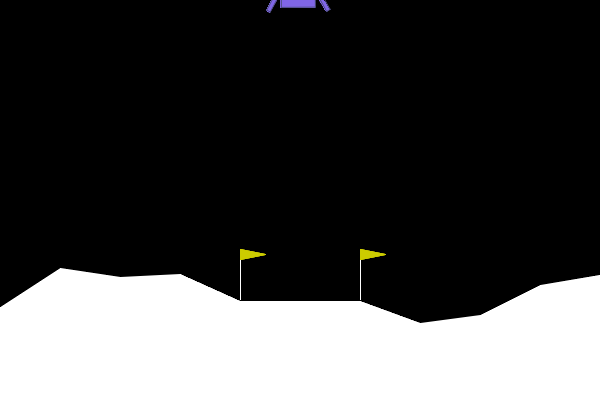

In [48]:
# .reset() method to reset the environemtn to initial state. lander starts at the top center of the environment and we can render the first frame 
# of the environmnet with .render() method
env.reset()
Image.fromarray(env.render())

In [49]:
# size of state vector and number of valid actions required to build neural netowrk later
state_size = env.observation_space.shape
num_actions = env.action_space.n

### 5 - Interacting with the Gym Environment

In the standard “agent-environment loop” formalism, an agent interacts with the environment in discrete time steps $t=0,1,2,...$. At each time step $t$, the agent uses a policy $\pi$ to select an action $A_t$ based on its observation of the environment's state $S_t$. The agent receives a numerical reward $R_t$ and on the next time step, moves to a new state $S_{t+1}$.

<a name="5.1"></a>
### 5.1 Exploring the Environment's Dynamics

In Open AI's Gym environments, we use the `.step()` method to run a single time step of the environment's dynamics. In the version of `gym` that we are using the `.step()` method accepts an action and returns four values:

* `observation` (**object**): an environment-specific object representing your observation of the environment. In the Lunar Lander environment this corresponds to a numpy array containing the positions and velocities of the lander as described in section [3.2 Observation Space](#3.2).


* `reward` (**float**): amount of reward returned as a result of taking the given action. In the Lunar Lander environment this corresponds to a float of type `numpy.float64` as described in section [3.3 Rewards](#3.3).


* `done` (**boolean**): When done is `True`, it indicates the episode has terminated and it’s time to reset the environment. 


* `info` (**dictionary**): diagnostic information useful for debugging. We won't be using this variable in this notebook but it is shown here for completeness.

To begin an episode, we need to reset the environment to an initial state. We do this by using the `.reset()` method. 

In [50]:
current_state = env.reset()

Once the environment is reset, the agent can start taking actions in the environment by using the `.step()` method. Note that the agent can only take one action per time step. 

In the cell below you can select different actions and see how the returned values change depending on the action taken. Remember that in this environment the agent has four discrete actions available and we specify them in code by using their corresponding numerical value:

```python
Do nothing = 0
Fire right engine = 1
Fire main engine = 2
Fire left engine = 3
```

In [61]:
# Select an action
action = 0

# Run a single time step of the environment's dynamics with the given action.
next_state, reward, done, _, _ = env.step(action)

# Display table with values.
#utils.display_table(current_state, action, next_state, reward, done)

# Replace the `current_state` with the state after the action is taken
current_state = next_state

## 6 - Deep Q-Learning

In cases where both the state and action space are discrete we can estimate the action-value function iteratively by using the Bellman equation:

$$
Q_{i+1}(s,a) = R + \gamma \max_{a'}Q_i(s',a')
$$

This iterative method converges to the optimal action-value function $Q^*(s,a)$ as $i\to\infty$. This means that the agent just needs to gradually explore the state-action space and keep updating the estimate of $Q(s,a)$ until it converges to the optimal action-value function $Q^*(s,a)$. However, in cases where the state space is continuous it becomes practically impossible to explore the entire state-action space. Consequently, this also makes it practically impossible to gradually estimate $Q(s,a)$ until it converges to $Q^*(s,a)$.

In the Deep $Q$-Learning, we solve this problem by using a neural network to estimate the action-value function $Q(s,a)\approx Q^*(s,a)$. We call this neural network a $Q$-Network and it can be trained by adjusting its weights at each iteration to minimize the mean-squared error in the Bellman equation.

Unfortunately, using neural networks in reinforcement learning to estimate action-value functions has proven to be highly unstable. Luckily, there's a couple of techniques that can be employed to avoid instabilities. These techniques consist of using a ***Target Network*** and ***Experience Replay***. We will explore these two techniques in the following sections.

### 6.1 Target Network

We can train the $Q$-Network by adjusting it's weights at each iteration to minimize the mean-squared error in the Bellman equation, where the target values are given by:

$$
y = R + \gamma \max_{a'}Q(s',a';w)
$$

where $w$ are the weights of the $Q$-Network. This means that we are adjusting the weights $w$ at each iteration to minimize the following error:

$$
\overbrace{\underbrace{R + \gamma \max_{a'}Q(s',a'; w)}_{\rm {y~target}} - Q(s,a;w)}^{\rm {Error}}
$$

Notice that this forms a problem because the $y$ target is changing on every iteration. Having a constantly moving target can lead to oscillations and instabilities. To avoid this, we can create
a separate neural network for generating the $y$ targets. We call this separate neural network the **target $\hat Q$-Network** and it will have the same architecture as the original $Q$-Network. By using the target $\hat Q$-Network, the above error becomes:

$$
\overbrace{\underbrace{R + \gamma \max_{a'}\hat{Q}(s',a'; w^-)}_{\rm {y~target}} - Q(s,a;w)}^{\rm {Error}}
$$

where $w^-$ and $w$ are the weights of the target $\hat Q$-Network and $Q$-Network, respectively.

In practice, we will use the following algorithm: every $C$ time steps we will use the $\hat Q$-Network to generate the $y$ targets and update the weights of the target $\hat Q$-Network using the weights of the $Q$-Network. We will update the weights $w^-$ of the the target $\hat Q$-Network using a **soft update**. This means that we will update the weights $w^-$ using the following rule:
 
$$
w^-\leftarrow \tau w + (1 - \tau) w^-
$$

where $\tau\ll 1$. By using the soft update, we are ensuring that the target values, $y$, change slowly, which greatly improves the stability of our learning algorithm.

### Exercise 1

In this exercise you will create the $Q$ and target $\hat Q$ networks and set the optimizer. Remember that the Deep $Q$-Network (DQN) is a neural network that approximates the action-value function $Q(s,a)\approx Q^*(s,a)$. It does this by learning how to map states to $Q$ values.

To solve the Lunar Lander environment, we are going to employ a DQN with the following architecture:

* An `Input` layer that takes `state_size` as input.

* A `Dense` layer with `64` units and a `relu` activation function.

* A `Dense` layer with `64` units and a `relu` activation function.

* A `Dense` layer with `num_actions` units and a `linear` activation function. This will be the output layer of our network.


In the cell below you should create the $Q$-Network and the target $\hat Q$-Network using the model architecture described above. Remember that both the $Q$-Network and the target $\hat Q$-Network have the same architecture.

Lastly, you should set `Adam` as the optimizer with a learning rate equal to `ALPHA`. Recall that `ALPHA` was defined in the [Hyperparameters](#2) section. We should note that for this exercise you should use the already imported packages:
```python
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

In [62]:
q_network = Sequential([
    Input(shape = state_size),
    Dense(64, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(num_actions, activation = 'linear')
])

target_q_network = Sequential([
    Input(shape = state_size),
    Dense(64, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(num_actions, activation = 'linear')
])

optimizer = Adam(learning_rate = ALPHA)

### 6.2 Experience Replay

When an agent interacts with the environment, the states, actions, and rewards the agent experiences are sequential by nature. If the agent tries to learn from these consecutive experiences it can run into problems due to the strong correlations between them. To avoid this, we employ a technique known as **Experience Replay** to generate uncorrelated experiences for training our agent. Experience replay consists of storing the agent's experiences (i.e the states, actions, and rewards the agent receives) in a memory buffer and then sampling a random mini-batch of experiences from the buffer to do the learning. The experience tuples $(S_t, A_t, R_t, S_{t+1})$ will be added to the memory buffer at each time step as the agent interacts with the environment.

For convenience, we will store the experiences as named tuples.

In [63]:
# Store experiences as named tuples
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

## 7 - Deep Q-Learning Algorithm with Experience Replay

Now that we know all the techniques that we are going to use, we can put them together to arrive at the Deep Q-Learning Algorithm With Experience Replay.

### Exercise 2

In this exercise you will implement line ***12*** of the algorithm outlined in *Fig 3* above and you will also compute the loss between the $y$ targets and the $Q(s,a)$ values. In the cell below, complete the `compute_loss` function by setting the $y$ targets equal to:

$$
\begin{equation}
    y_j =
    \begin{cases}
      R_j & \text{if episode terminates at step  } j+1\\
      R_j + \gamma \max_{a'}\hat{Q}(s_{j+1},a') & \text{otherwise}\\
    \end{cases}       
\end{equation}
$$

Here are a couple of things to note:

* The `compute_loss` function takes in a mini-batch of experience tuples. This mini-batch of experience tuples is unpacked to extract the `states`, `actions`, `rewards`, `next_states`, and `done_vals`. You should keep in mind that these variables are *TensorFlow Tensors* whose size will depend on the mini-batch size. For example, if the mini-batch size is `64` then both `rewards` and `done_vals` will be TensorFlow Tensors with `64` elements.


* Using `if/else` statements to set the $y$ targets will not work when the variables are tensors with many elements. However, notice that you can use the `done_vals` to implement the above in a single line of code. To do this, recall that the `done` variable is a Boolean variable that takes the value `True` when an episode terminates at step $j+1$ and it is `False` otherwise. Taking into account that a Boolean value of `True` has the numerical value of `1` and a Boolean value of `False` has the numerical value of `0`, you can use the factor `(1 - done_vals)` to implement the above in a single line of code. Here's a hint: notice that `(1 - done_vals)` has a value of `0` when `done_vals` is `True` and a value of `1` when `done_vals` is `False`. 

Lastly, compute the loss by calculating the Mean-Squared Error (`MSE`) between the `y_targets` and the `q_values`. To calculate the mean-squared error you should use the already imported package `MSE`:
```python
from tensorflow.keras.losses import MSE
```

In [64]:
def compute_loss(experiences, gamma, q_network, target_q_network):
    """ 
    Calculates the loss.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
      q_network: (tf.keras.Sequential) Keras model for predicting the q_values
      target_q_network: (tf.keras.Sequential) Keras model for predicting the targets
          
    Returns:
      loss: (TensorFlow Tensor(shape=(0,), dtype=int32)) the Mean-Squared Error between
            the y targets and the Q(s,a) values.
    """

    # Unpack the mini-batch of experience tuples
    states, actions, rewards, next_states, done_vals = experiences
    # Compute max Q^(s, a)
    max_qsa = tf.reduce_max(target_q_network(next_states), axis = -1)

    # Set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a).
    y_targets = rewards + ((1-done_vals) * gamma * max_qsa)

    # Get q_values and reshape to match target
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]), tf.cast(actions, tf.int32)], axis=1))

    # Compute loss
    loss = MSE(y_targets, q_values)

    return loss
        
